# pipeline2 model test

## (according to the code on the group github)

In [146]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
import statsmodels.api as sm
random.seed(3888)
np.random.seed(3888)

target_path = "order_book_target.parquet"
feature_path = "order_book_feature.parquet"

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


combined_df = combined_df[combined_df['stock_id'] == 50200]

combined_df.head()





,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500


## Feature Engineering


In [148]:
def compute_orderbook_features(combined_df):
    spy_data = combined_df.copy()

    # === 基础特征计算 ===
    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']
    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)

    spy_data['wap_lag1'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    spy_data['wap_return'] = (spy_data['wap'] - spy_data['wap_lag1']) / spy_data['wap_lag1']
    spy_data['log_return'] = np.log(spy_data['wap'] / spy_data['wap_lag1'].replace(0, np.nan))

    spy_data['wap_mean_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    spy_data['wap_std_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())

    # === Realized Volatility ===
    rv_df = spy_data.groupby(['stock_id', 'time_id'])['log_return'].agg(
        lambda x: np.sqrt(np.sum(x ** 2))
    ).reset_index().rename(columns={"log_return": "realized_volatility"})

    spy_data = pd.merge(spy_data, rv_df, on=["stock_id", "time_id"], how="left")

    # === HAR-RV ===
    spy_data = spy_data.sort_values(by=['stock_id', 'time_id'])
    spy_data['RV_lag1'] = spy_data.groupby('stock_id')['realized_volatility'].shift(1)
    spy_data['RV_lag5'] = spy_data.groupby('stock_id')['realized_volatility'].rolling(window=5).mean().reset_index(level=0, drop=True).shift(1)
    spy_data['RV_lag22'] = spy_data.groupby('stock_id')['realized_volatility'].rolling(window=22).mean().reset_index(level=0, drop=True).shift(1)

    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation', 'bid_ask_spread',
        'imbalance', 'depth_ratio',
        'realized_volatility', 'RV_lag1', 'RV_lag5', 'RV_lag22'
    ]
    return spy_data[keep_cols]



In [149]:

time_ref_df = pd.read_csv("time_id_reference.csv")
time_ref_df.head()

feature_engineered_df = compute_orderbook_features(combined_df)

In [150]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,wap_lag1,wap_return,log_return,wap_mean_10,wap_std_10,spread_pct,spread_variation,bid_ask_spread,imbalance,depth_ratio,realized_volatility,RV_lag1,RV_lag5,RV_lag22,datetime
4166783,50200,1199,3595.0,438.471429,438.496250,-0.000057,-0.000057,438.496120,0.048162,0.000023,0.000011,0.01,-0.714286,0.166667,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166784,50200,1199,3596.0,438.490714,438.471429,0.000044,0.000044,438.488555,0.041364,0.000023,0.000011,0.01,-0.857143,0.076923,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166785,50200,1199,3597.0,438.491579,438.490714,0.000002,0.000002,438.480113,0.027986,0.000023,0.000010,0.01,-0.684211,0.187500,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166786,50200,1199,3598.0,438.547500,438.491579,0.000128,0.000128,438.481828,0.031688,0.000023,0.000010,0.01,0.500000,3.000000,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166787,50200,1199,3599.0,438.577500,438.547500,0.000068,0.000068,438.493225,0.042891,0.000023,0.000007,0.01,0.500000,3.000000,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00


## Hav-rv ols and wls


### test and train

In [153]:
feature_engineered_df = compute_orderbook_features(combined_df)


unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

train_data = pd.concat([X_train, y_train], axis=1).dropna()
test_data = pd.concat([X_test, y_test], axis=1).dropna()


X_train = train_data[['RV_lag1', 'RV_lag5', 'RV_lag22']]
y_train = train_data['bid_ask_spread']

X_test = test_data[['RV_lag1', 'RV_lag5', 'RV_lag22']]
y_test = test_data['bid_ask_spread']


In [154]:
# OLS
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)

# WLS 
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

weights = 1 / (X_train['RV_lag1'] + 1e-6)

wls_model = sm.WLS(y_train, X_train_sm, weights=weights)
wls_results = wls_model.fit()
y_pred_wls = wls_results.predict(X_test_sm)

# QLIKE
def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None) 
    return np.mean(np.log(y_pred**2) + (y_true**2) / (y_pred**2))


print("=== OLS ===")
print("MSE:", round(mean_squared_error(y_test, y_pred_ols), 6))
print("QLIKE:", round(qlike(y_test.values, y_pred_ols), 6))

print("\n=== WLS ===")
print("MSE:", round(mean_squared_error(y_test, y_pred_wls), 6))
print("QLIKE:", round(qlike(y_test.values, y_pred_wls), 6))

=== OLS ===
MSE: 1.7e-05
QLIKE: -7.698238

=== WLS ===
MSE: 1.7e-05
QLIKE: -7.69828


## XGboost


### test and train

In [169]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 'RV_lag1', 'RV_lag5', 'RV_lag22', 'bid_ask_spread'

feature_engineered_df['RV_lag1_mean'] = feature_engineered_df['RV_lag1'].rolling(window=3, min_periods=1).mean()
feature_engineered_df['RV_lag1_std']  = feature_engineered_df['RV_lag1'].rolling(window=3, min_periods=1).std()

feature_engineered_df['RV_lag5_mean'] = feature_engineered_df['RV_lag5'].rolling(window=3, min_periods=1).mean()
feature_engineered_df['RV_lag5_std']  = feature_engineered_df['RV_lag5'].rolling(window=3, min_periods=1).std()

feature_engineered_df['RV_lag22_mean'] = feature_engineered_df['RV_lag22'].rolling(window=3, min_periods=1).mean()
feature_engineered_df['RV_lag22_std']  = feature_engineered_df['RV_lag22'].rolling(window=3, min_periods=1).std()

X_cols = [
    'RV_lag1', 'RV_lag1_mean', 'RV_lag1_std',
    'RV_lag5', 'RV_lag5_mean', 'RV_lag5_std',
    'RV_lag22', 'RV_lag22_mean', 'RV_lag22_std'
]
y_col = 'bid_ask_spread'

y_col = 'bid_ask_spread'

df_clean = feature_engineered_df.dropna(subset=X_cols + [y_col])
X = df_clean[X_cols]
y = df_clean[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




 MSE: 1.664e-05
 QLIKE: -7.70560913


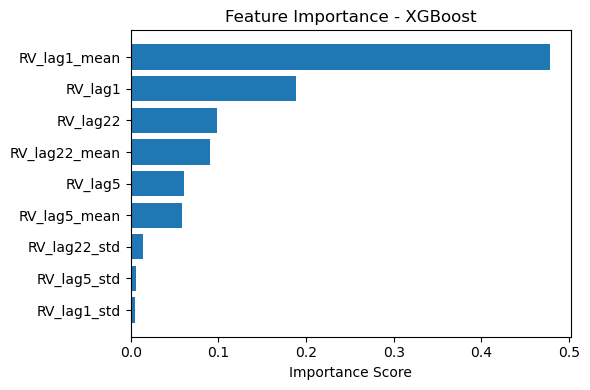

In [171]:
#  XGBoost 
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None)  
    return np.mean(np.log(y_pred**2) + (y_true**2) / (y_pred**2))


mse = mean_squared_error(y_test, y_pred)
qlike_score = qlike(y_test.values, y_pred)

print(" MSE:", round(mse, 8))
print(" QLIKE:", round(qlike_score, 8))

importance_df = pd.DataFrame({
    'Feature': model.feature_names_in_,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)


plt.figure(figsize=(6, 4)) 
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

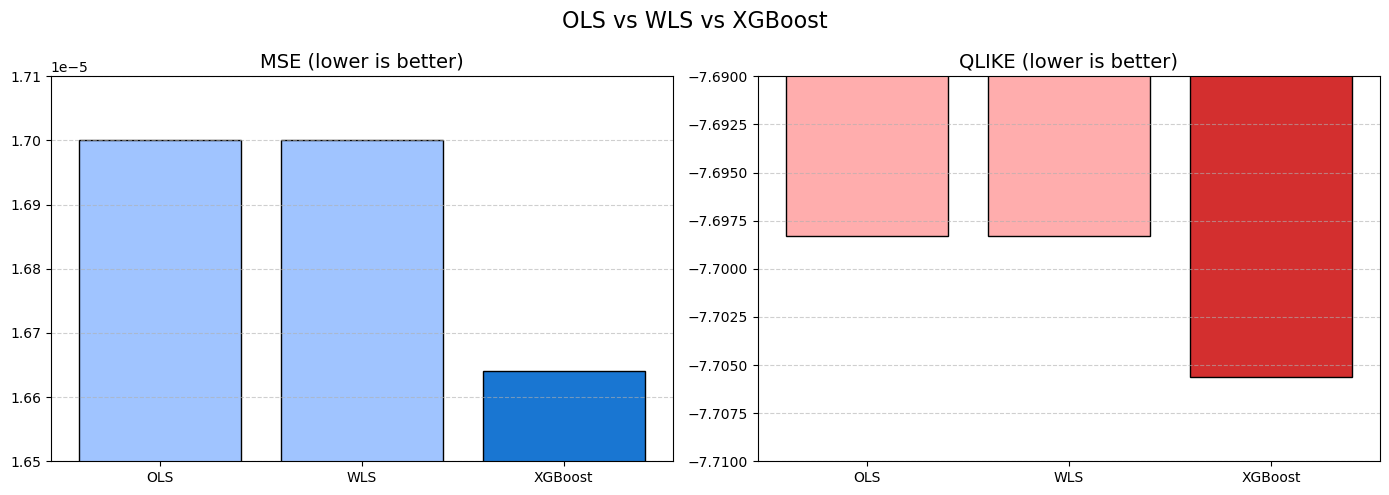

In [187]:

models = ['OLS', 'WLS', 'XGBoost']
mse_scores = [1.7e-05, 1.7e-05, 1.664e-05]
qlike_scores = [-7.69828, -7.69828, -7.70560913]

#  find the best model
best_mse_idx = np.argmin(mse_scores)
best_qlike_idx = np.argmin(qlike_scores)

 # deep blue
mse_colors = ['#A0C4FF'] * 3
mse_colors[best_mse_idx] = '#1976D2' 

 # deep red
qlike_colors = ['#FFADAD'] * 3
qlike_colors[best_qlike_idx] = '#D32F2F' 

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# MSE plot
bars1 = axs[0].bar(models, mse_scores, color=mse_colors, edgecolor='black')
axs[0].set_title('MSE (lower is better)', fontsize=14)
axs[0].set_ylim(1.65e-5, 1.71e-5)
axs[0].grid(axis='y', linestyle='--', alpha=0.6)


# QLIKE plot
bars2 = axs[1].bar(models, qlike_scores, color=qlike_colors, edgecolor='black')
axs[1].set_title('QLIKE (lower is better)', fontsize=14)
axs[1].set_ylim(-7.71, -7.69)
axs[1].grid(axis='y', linestyle='--', alpha=0.6)


plt.suptitle('OLS vs WLS vs XGBoost' , fontsize=16)
plt.tight_layout()
plt.show()

